# Build a Convolutional VAE and train it on Cifar10

As we already mentioned during the lesson, here you are on your own. You will have to build everything from scratch. Your goal is to build a convolutional VAE of your own structure and train it on CIFAR10. Hyperparameters, optimizers, losses are also your own choice. 

Of course you can and should borrow stuff from the lessons and previous Jupyter notebooks.This is especially true for the data loading functionalities. You should use our custom CIFAR10 dataloader, as we did in the previous exercises.

As always, feel free to advice the Pytorch documentation (links in the Appendix). Please make sure to have a working code before you leave. Good luck.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import utils
from torchvision import transforms

In [3]:
from torchvision.datasets import CIFAR10

In [4]:
# Commenting out for local run. This cell is required for executing the notebook in the course website's environment.
# import os
# import sys
# cwd = os.getcwd()
#add CIFAR10 data in the environment
# sys.path.append(cwd + '/../cifar10') 
# from Cifar10Dataloader import CIFAR10

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [7]:
batch_size = 4
normalize_mean = 0.5
normalize_std = 0.2

In [8]:
def show_image(img):
    # unnormalize
    img = img*normalize_std + normalize_mean
    plt.imshow(np.transpose(img.numpy(), [1,2,0]))
    plt.show()

In [9]:
def load_data(shuffle=False):
    #convert the images to tensor and normalized them
    transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize((normalize_mean, normalize_mean, normalize_mean), (normalize_std, normalize_std, normalize_std))
        ])

    trainset = CIFAR10(root='~/data/cifar10',  download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=shuffle, num_workers=1)
    return trainloader

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # self.features = 16
        # ----- encoder -----
        # self.enc1 = nn.Linear(in_features=3072, out_features=128)
        # self.enc2 = nn.Linear(in_features=128, out_features=self.features * 2)

        self.encoder = nn.Sequential(
            # Layer #1: Conv2d, Output shape: [-1, 12, 16, 16]
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            # Layer #3: Conv2d, Output shape: [-1, 24, 8, 8]
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            # Layer #5: Conv2d, Output shape: [-1, 48, 4, 4]
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=4, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            # Layer #7: Conv2d, Output shape: [-1, 96, 2, 2]
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=4, stride=2, padding=1, dilation=1),
            nn.ReLU()
        )

        # ----- decoder -----
        # self.dec1 = nn.Linear(in_features=self.features, out_features=128)
        # self.dec2 = nn.Linear(in_features=128, out_features=3072)

        self.decoder = nn.Sequential(
            # Layer #9: ConvTranspose2d, Output shape: [-1, 48, 4, 4]
            nn.ConvTranspose2d(in_channels=48, out_channels=48, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.ReLU(),
            # Layer #11: ConvTranspose2d, Output shape: [-1, 24, 8, 8]
            nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.ReLU(),
            # Layer #13: ConvTranspose2d, Output shape: [-1, 12, 16, 16]
            nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.ReLU(),
            # Layer #15: ConvTranspose2d, Output shape: [-1, 3, 32, 32]
            nn.ConvTranspose2d(in_channels=12, out_channels=3, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1)
        )

    def forward(self, x):
        # encoding
        #x = F.relu(self.enc1(x))
        #x = self.enc2(x).view(-1, 2, self.features)
        x = self.encoder(x)
        x = x.view(-1, 2, 96*2)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :]  # the first feature values as mean
        log_var = x[:, 1, :]  # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        # print(f"z.shape: {z.shape}")

        z = z.view(-1, 48, 2, 2)

        # decoding
        # x = F.relu(self.dec1(z))
        # reconstruction = torch.sigmoid(self.dec2(x))
        # reconstruction = self.dec2(x)
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)  # generate sample of the same size
        sample = mu + (eps * std)  # sampling as if coming from the input space
        return sample

In [11]:
def final_loss(recon_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param recon_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    RL = recon_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RL + KLD

In [12]:
def train(model,training_data):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss(reduction="sum")

    running_loss = 0.0

    for epoch in range(6):  # loop over the dataset multiple times

        for i, data in enumerate(training_data, 0):
            inputs, _ = data
            # inputs = inputs.view(inputs.size(0), -1)
            # print(f"min(inputs): {torch.min(input=inputs)} :: max(inputs): {torch.max(input=inputs)}")

            optimizer.zero_grad()
            reconstruction, mu, logvar = model(inputs)
            # print(f"min(reconstruction): {torch.min(input=reconstruction)} :: max(reconstruction): {torch.max(input=reconstruction)}")
            recon_loss = criterion(reconstruction, inputs)
            loss = final_loss(recon_loss, mu, logvar)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:  # print every 500 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    PATH = '../output/cifar_net.pth'
    torch.save(model.state_dict(), PATH)

    print('Finished Training')

In [13]:
def main():
    trainloader = load_data()
    model = VAE()
    train(model=model, training_data=trainloader)

In [14]:
main()

Files already downloaded and verified
[1,   500] loss: 4359.911
[1,  1000] loss: 3399.967
[1,  1500] loss: 3231.241
[1,  2000] loss: 3124.551
[1,  2500] loss: 3095.119
[1,  3000] loss: 3018.428
[1,  3500] loss: 3031.007
[1,  4000] loss: 2974.783
[1,  4500] loss: 2976.813
[1,  5000] loss: 2943.912
[1,  5500] loss: 2891.939
[1,  6000] loss: 2913.427
[1,  6500] loss: 2915.547
[1,  7000] loss: 2873.350
[1,  7500] loss: 2926.404
[1,  8000] loss: 2875.234
[1,  8500] loss: 2778.250
[1,  9000] loss: 2802.549
[1,  9500] loss: 2826.257
[1, 10000] loss: 2705.231
[1, 10500] loss: 2747.722
[1, 11000] loss: 2714.105
[1, 11500] loss: 2707.686
[1, 12000] loss: 2702.888
[1, 12500] loss: 2697.471
[2,   500] loss: 2723.527
[2,  1000] loss: 2712.778
[2,  1500] loss: 2694.932
[2,  2000] loss: 2689.492
[2,  2500] loss: 2696.545
[2,  3000] loss: 2659.175
[2,  3500] loss: 2687.416
[2,  4000] loss: 2673.111
[2,  4500] loss: 2694.163
[2,  5000] loss: 2669.231
[2,  5500] loss: 2645.548
[2,  6000] loss: 2670.772


In [15]:
def evaluate(model, n_batch=5):
    dataiter = iter(load_data(shuffle=True))

    for batch_i in range(n_batch):
        images, _ = next(dataiter)

        # display images
        show_image(utils.make_grid(images))
        
        recon_images, _, _ = model(images)
        show_image(utils.make_grid(recon_images))

Files already downloaded and verified


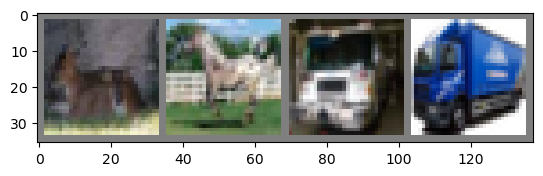

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


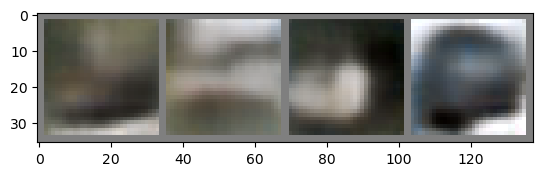

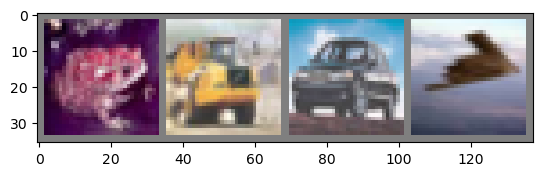

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


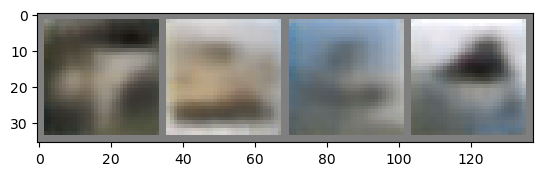

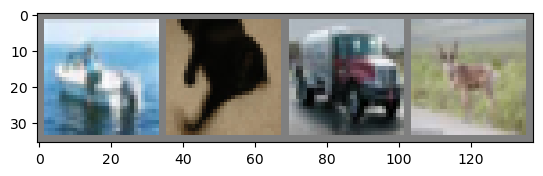

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


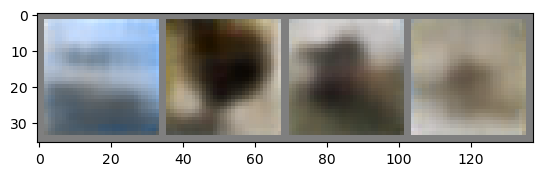

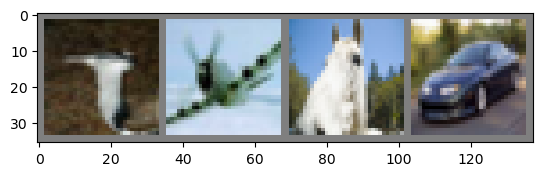

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


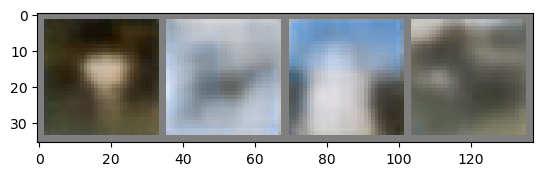

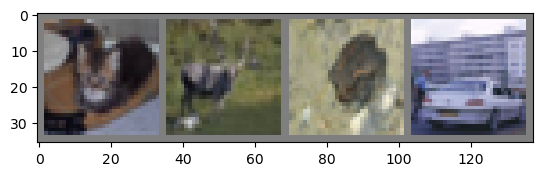

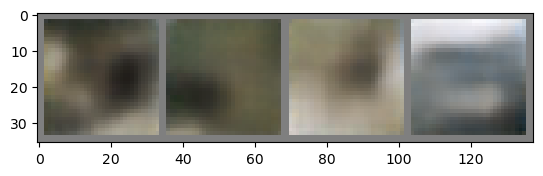

In [16]:
model = VAE()
model.load_state_dict(torch.load("../output/cifar_net.pth"))

evaluate(model)